In [14]:
import datetime
from pytz import timezone

# from collections import OrderedDict
from copy import deepcopy

import time
import numpy as np
import copy
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [45]:
# PARAMETERS FOR 
LAMBDA_PEN = 1000
L_BOUND = -10
U_BOUND = 10
N_POINTS = 512

NUM_EPOCHS = 5000

M_POINTS = 10
ALPHA = 2

SELECTION_RATE = 0.01

DISCRETE_POINTS = np.linspace(L_BOUND, U_BOUND, N_POINTS)

In [28]:
class sinFn(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)

In [17]:
# PLOT DATA
def plot_figure(x_val, y_val, x_test=None, predicted=None, log_scale=False):
    plt.clf()
    plt.figure(figsize=(8, 6), dpi=80)
    if log_scale==True:
        plt.yscale('log')
    plt.plot(x_val, y_val, '--', label='True data', alpha=0.5)
    if predicted != None:
        plt.plot(x_test, predicted, '--', label='Predictions', alpha=0.5)
    plt.legend(loc='best')
    plt.show()

In [18]:
class X_Square_sin:
    def __init__(self, const, use_sin=False):
        self.const = const
        if use_sin == True:
            self.sin_const = np.random.choice(np.arange(10, 50))
        
    def forward(self, x):
        return x**2 + self.const + self.sin_const*math.sin(x)
    
class Potential_Function:
    def __init__(self, c_0=0,
                 M_points=M_POINTS,
                 L_endpoint=U_BOUND, 
                 alpha=ALPHA, 
                 rescale=1):
        self.M_points = M_points
        self.L_endpoint = L_endpoint
        self.alpha = alpha
        self.c_0 = c_0
        self.rescale = 1
        
        self.ti_list = np.random.normal(loc=0, scale=1.0, size= self.M_points)
        self.ci_list = [(self.L_endpoint/(i * math.pi))**self.alpha 
                        for i in range(1, self.M_points+1)]
        
    def forward(self, x):
        f_value = 0
        summation = 0
        
        #Iterative method:

        for i in range(1, self.M_points+1):
            cos_val = np.cos((i * math.pi * x)/self.L_endpoint)
            summation += self.ti_list[i-1] * self.ci_list[i-1] * cos_val

        f_value += summation
        f_value += self.c_0
        return self.rescale * f_value
    
    def set_c0_value(self, val):
        self.c_0 = val
        return
    
    def set_rescale_factor(self, val):
        self.rescale = val
        return 
    
    def plot_function(self, discrete_points):
        y_values = [self.forward(i) for i in discrete_points]
        plt.plot(discrete_points, y_values)
    
    def update_potential_fn(self, discrete_points):
        # (1) Check lowest value to set appropriate c_0 value:
        y_values = [self.forward(i) for i in discrete_points]
        min_val = min(y_values)
        print("Original min val = " + str(min_val))
        # plt.plot(DISCRETE_POINTS, y_values)

        # (1) Set c_0 value s.t. every value in y_values is > 0: 
        if min_val < 0:
            c_0 = math.ceil(abs(min_val))
            self.set_c0_value(c_0)
            new_y = [self.forward(i) for i in discrete_points]
            print("Min val with c_0 updated = " + str(min(new_y)))
        # plt.plot(DISCRETE_POINTS, new_y)

        # (2) Rescale potential function s.t. every value lies between 0 and 5:
        max_v = max(new_y)
#         min_v = min(new_y)
#         print(max_v, min_v)
#         max_min = max_v-min_v

#         rescaled_y = [(i-min_v)/(max_min) for i in new_y]
#         plt.plot(DISCRETE_POINTS, rescaled_y)

        c = 5/max_v
        self.set_rescale_factor(c)
        return

In [19]:
def epsilon_Loss_penalty(v_x, model_u, 
                         lambda_pen,
                         upper_bound, 
                         discrete_points):
    eps_sum = 0
    pen = 0

    h = (2*upper_bound)/(len(discrete_points)-1)
#     print("h = "+ str(h))
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)

        u_prime_square = torch.square(model_u.u_prime(x_i))
        u_xi_square = torch.square(model_u(x_i))
        
        v_xi = v_x.forward(i)
        if v_xi < 0:
            raise ValueError('Potential Function value is < 0')

        t = u_prime_square + v_xi*u_xi_square
        eps_sum += t
        
        pen+= u_xi_square
        
    epsilon_fn = h*eps_sum
    
    penalty = lambda_pen * torch.square(h*pen-1)
#     print("epsilon_fn value = " + str(epsilon_fn))
#     print("penalty value = " + str(penalty))
    return (epsilon_fn, epsilon_fn + penalty)

In [33]:
class Nonlinear_2(nn.Module):
    """
    Neural Network with 2 layers
    """
    def __init__(self, layer_width, use_sin=False):
        super(Nonlinear_2, self).__init__()
        
        self.sigmoid = nn.Sigmoid()
        self.sin = sinFn()
#         self.tanh = nn.Tanh()
        self.use_sin = use_sin
        
        self.hidden1 = nn.Linear(1, layer_width)
        self.hidden2 = nn.Linear(layer_width, layer_width)
        self.output = nn.Linear(layer_width, 1)
        
    def forward(self, x):
        if self.use_sin == True:
            x = self.hidden1(x)
            x = self.sin(x)
            
            x = self.hidden2(x)
            x = self.sin(x)
            
            x = self.output(x)
            
        else:
            x = self.hidden1(x)
            x = self.sigmoid(x)
            
            x = self.hidden2(x)
            x = self.sigmoid(x)
            
            x = self.output(x)
        return x

    def normalize_model(self, upper_bound, discrete_points):
        """
        GOAL: Normalize the output weight layer
        model.output *= c
        where,
        scalar c = 1/denom
        """
        
        h = (2*upper_bound)/(len(discrete_points)-1)
        if h != (discrete_points[1]-discrete_points[0]):
            raise ValueError("h is wrong!")
        s = 0
        for i in discrete_points:
            x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
            s += self(x_i)**2
        denom = math.sqrt(h) * torch.sqrt(s)
        c = 1/denom

        print("Before normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        
        self.output.weight.data.copy_(c.item() * self.output.weight.data)
        self.output.bias.data.copy_(c.item() * self.output.bias.data)

        print("After normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        print("c value = " + str(c))

        return 

    def u_prime(self, x_in):
        y = self(x_in)
        y_prime = torch.autograd.grad(y.sum(), x_in, create_graph=True)
        return y_prime[0]

In [34]:
# CREATING MODEL CLASS
class Nonlinear_1(nn.Module):
    """
    Neural Network with 1 layers
    """
    def __init__(self, layer_width, use_sin=False):
        super(Nonlinear_1, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.sin = sinFn()
        self.use_sin = use_sin
#         self.tanh = nn.Tanh()

        self.hidden = nn.Linear(1, layer_width)
        self.output = nn.Linear(layer_width, 1)

            
    def forward(self, x):
        if self.use_sin == True:
            x = self.hidden(x)
            x = self.sin(x)
            x = self.output(x)
        else:
            x = self.hidden(x)
            x = self.sigmoid(x)
            x = self.output(x)
        return x

    def normalize_model(self, upper_bound, discrete_points):
        """
        GOAL: Normalize the output weight layer
        model.output *= c
        where,
        scalar c = 1/denom
        """
        
        h = (2*upper_bound)/(len(discrete_points)-1)
        if h != (discrete_points[1]-discrete_points[0]):
            raise ValueError("h is wrong!")
        s = 0
        for i in discrete_points:
            x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
            s += self(x_i)**2
        denom = math.sqrt(h) * torch.sqrt(s)
        c = 1/denom

        print("Before normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        
        self.output.weight.data.copy_(c.item() * self.output.weight.data)
        self.output.bias.data.copy_(c.item() * self.output.bias.data)

        print("After normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        print("c value = " + str(c))

        return 

    def u_prime(self, x_in):
        y = self(x_in)
        y_prime = torch.autograd.grad(y.sum(), x_in, create_graph=True)
        return y_prime[0]

In [13]:
# TRANING MODEL
def minibatch_train_with_penalty(model, 
                               num_epochs, 
                               v_x, 
                               optimizer, 
                               lambda_pen,
                               discrete_points,
                               batch_size=32):
    # For plotting loss value over epochs:
    x_epochs = []
    y_loss = []
    y_loss_pen = []

    m = len(discrete_points)
    num_batches = int(m/batch_size)
#         print("Number of batches " + str(num_batches))

    for epoch in range(num_epochs):
        perm = torch.randperm(m)
        avg_loss_pen = 0
        avg_loss = 0

#                 start1 = time.time()
        for i in range(0, m, batch_size):
#                 print("i = " + str(i))
            optimizer.zero_grad()

            indices = perm[i: i+batch_size]

            loss_values = epsilon_Loss_penalty(v_x, model, lambda_pen,
                                            U_BOUND, 
                                            discrete_points[indices])

            loss = loss_values[0]
            loss_pen = loss_values[1]

            avg_loss_pen += loss_pen.item()
            avg_loss += loss.item()

            loss_pen.backward()
            optimizer.step()

        avg_loss_pen = avg_loss_pen/num_batches
        avg_loss = avg_loss/num_batches

        y_loss_pen.append(avg_loss_pen)
        y_loss.append(avg_loss)
        x_epochs.append(epoch)

        if epoch % 100 == 0 or epoch < 30:
            print('epoch {}, loss with penalty {}'.format(epoch, avg_loss_pen))

#                 if epoch == 0:
#                     end1 = time.time()
#                     time1 = end1-start1
#                     print("One epoch takes " + str(time1))

    print('Please normalize after training')
    return (x_epochs, y_loss_pen, y_loss)

def batch_train_with_penalty(model, 
                         num_epochs, 
                         v_x, 
                         optimizer, 
                         lambda_pen, 
                         discrete_points):
    # For plotting loss value over epochs:
    x_epochs = []
    y_loss = []
    y_loss_pen = []

    #Early stopping criteria:
    last_min_loss = 2.0
    patience = 4
    min_delta = 1e-3 #minimum difference to be considered better loss
    stop_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss_values = epsilon_Loss_penalty(v_x, model, lambda_pen,
                                    U_BOUND, discrete_points)

        loss = loss_values[0]
        loss_pen = loss_values[1]

        y_loss_pen.append(loss_pen.detach().numpy().item())
        y_loss.append(loss.detach().numpy().item())
        x_epochs.append(epoch)

#             if epoch == 0:
#                 last_min_loss = loss_pen
#             else:
#             #Early stopping
#                 if abs(loss_pen-last_min_loss) <= min_delta:
#                     stop_counter += 1
#                     print("Stop counter + 1, current stop counter = " + str(stop_counter))
#                     if loss_pen < last_min_loss:
#                         last_min_loss = loss_pen
#                         best_model = copy.deepcopy(self.state_dict())

#                     if stop_counter >= patience:
#                         print("Early stopping. Training is complete")
#                         print('Please normalize after training')
#                         return (x_epochs, y_loss_pen, y_loss)
#                 else:
#                     stop_counter = 0

        if loss_pen < last_min_loss and abs(loss_pen-last_min_loss) >= min_delta:
            print("New min loss = " + str(loss_pen))
            best_model = copy.deepcopy(model)
            last_min_loss = loss_pen

#             if epoch % 100 == 0 or epoch < 30:
        print('epoch {}, loss with penalty {}'.format(epoch, loss_pen.item()))
        loss_pen.backward()
        optimizer.step()

    print('Please normalize after training')
    return (x_epochs, y_loss_pen, y_loss, best_model)

In [35]:
learningRate = 0.01

#INIT MODEL
model_1_1_sin = Nonlinear_1(20, use_sin=True)
model_1_1_sigmoid = Nonlinear_1(20)

if torch.cuda.is_available():
    model_1_1_sin.cuda()
    model_1_1_sigmoid.cuda()

# INIT OPTIMIZER CLASS
# Adam:
adam_opt_11_sin = torch.optim.Adam(model_1_1_sin.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

adam_opt_11_sigmoid = torch.optim.Adam(model_1_1_sigmoid.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

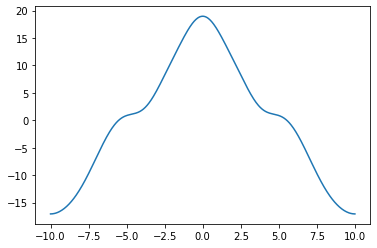

In [48]:
# INIT POTENTIAL FUNCTIONS
p_fn1 = Potential_Function()
p_fn1.plot_function(DISCRETE_POINTS)

Original min val = -17.070161763267283
Min val with c_0 updated = 0.9298382367327171


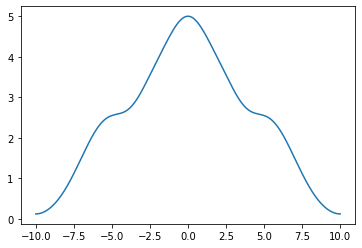

In [50]:
p_fn1.update_potential_fn(DISCRETE_POINTS)
p_fn1.plot_function(DISCRETE_POINTS)

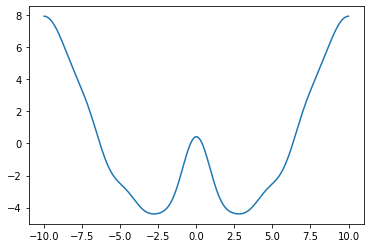

In [42]:
p_fn2 = Potential_Function()
p_fn2.plot_function(DISCRETE_POINTS)

Original min val = -4.394594810319068
Min val with c_0 updated = 0.6054051896809316


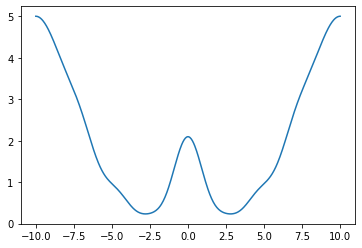

In [43]:
p_fn2.update_potential_fn(DISCRETE_POINTS)
p_fn2.plot_function(DISCRETE_POINTS)

In [ ]:
batch_train_with_penalty(model_1_1_sin, 
                         NUM_EPOCHS,
                         p_fn1,
                         adam_opt_11_sin,
                         LAMBDA_PEN,
                         DISCRETE_POINTS)

epoch 0, loss with penalty 12746.349609375
epoch 1, loss with penalty 4580.22509765625
epoch 2, loss with penalty 1351.51171875
epoch 3, loss with penalty 285.04583740234375
epoch 4, loss with penalty 22.618019104003906
epoch 5, loss with penalty 13.852798461914062
epoch 6, loss with penalty 56.586063385009766
epoch 7, loss with penalty 80.75733947753906
epoch 8, loss with penalty 70.0332260131836
epoch 9, loss with penalty 36.110408782958984
epoch 10, loss with penalty 6.257083892822266
epoch 11, loss with penalty 8.442904472351074
epoch 12, loss with penalty 48.077674865722656
epoch 13, loss with penalty 94.04878997802734
epoch 14, loss with penalty 108.0234146118164
epoch 15, loss with penalty 82.69295501708984
epoch 16, loss with penalty 40.4708251953125
epoch 17, loss with penalty 9.125713348388672
New min loss = tensor([1.9426], grad_fn=<AddBackward0>)
epoch 18, loss with penalty 1.942589282989502
epoch 19, loss with penalty 14.156079292297363
epoch 20, loss with penalty 32.04784

### The Finite Difference Method

In [ ]:
def finite_diff_method(lower_bound, upper_bound, N_points, given_fn):
    discrete_points = np.linspace(lower_bound, upper_bound, N_points)
    h = discrete_points[1]-discrete_points[0]
    c = np.sqrt(1/h)

    H = np.zeros((N_points,N_points))
    # Question: Why H has dimension (N-2) x (N-2)?
    V = np.zeros((N_points,N_points))

    for i in range (N_points):
        for j in range (N_points):
            if i == j:
                H[i][j] = -2
            elif abs(i-j) == 1:
                H[i][j] = 1
    for i in range (N_points):
        for j in range (N_points):
            if i == j:
                V[i][j] = given_fn.forward(discrete_points[i])

    A = -H/(h**2) + V
    
    eig_val, eig_vec = np.linalg.eig(A)
    sorted_id_eig_val = np.argsort(eig_val)
    # Get the indices that would sort eig_val
    z = sorted_id_eig_val[0:1]
    # eig_val[z] will return sorted first [T] value of eigenvalues.
    energies = eig_val[z]/eig_val[z][0]

    ground_state = c * eig_vec[:,z[0]]

    return (eig_val[z], ground_state)

In [ ]:
def plot_finite_diff_sol(eig_val, ground_state, discrete_points, nn_model=None):
    plt.figure(figsize=(12,10))
    for i in range(len(eig_val)):
        y = []
        y = np.append(y, (-1) * -ground_state)

        plt.plot(discrete_points,y,lw=3, label="{} ".format(i))
        plt.xlabel('x', size=14)
        plt.ylabel('$\psi$(x)',size=14)
    if nn_model != None:
        model_output = model_on_interval(nn_model, DISCRETE_POINTS)
        plt.plot(discrete_points, model_output)
    plt.legend()
#     plt.title('normalized wavefunctions for a harmonic oscillator using finite difference method',size=14)
    plt.show()
    return

In [ ]:
eig_val, ground_state = finite_diff_method(L_BOUND, U_BOUND, N_POINTS, pt_fn)
plot_finite_diff_sol(eig_val, ground_state, DISCRETE_POINTS, nn_model)